In [133]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine

from urllib.parse import quote_plus as urlquote
from sqlalchemy.engine import create_engine
from sqlalchemy_utils import create_database, database_exists

In [134]:
## Loading json file
df = pd.read_csv('insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Hypothesis 1

State the Hypothesis & Null Hypothesis


- $H_0$ (Null Hypothesis):The smoker have the same charges than non-smokers
- $H_A$ (Alternative Hypothesis): The smokers have higher charges than non-smokers

- Choosing test 
    - **The appropriate test to perform would be:**
        - Since we are measuring a numeric quantity (Charges)
        - and we are comparing 2 groups(smokers and non-smokers). 
        - We therefore want to perform a 2-sample t-test, A.K.A. an independent t-test.
    
- **According the the work flow, the 2-sample T-Test has the following assumptions:** 
    - No significant outliers
    - Normality
    - Equal Variance

## Getting the Group Data 

- The next step is to get the data for each group in separate variables. All of the approaches below will lead to the same result: a `has discount` and `no discount` variable.

### Data

In [135]:
# see how many with and without strength
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [136]:
# Filtering out those with and without super strength
smokers_df = df.loc[df['smoker']== 'yes'].copy()
non_smoker_df = df.loc[df['smoker']== 'no'].copy()



In [137]:
smoker = smokers_df['charges']
non_smoker = non_smoker_df['charges']

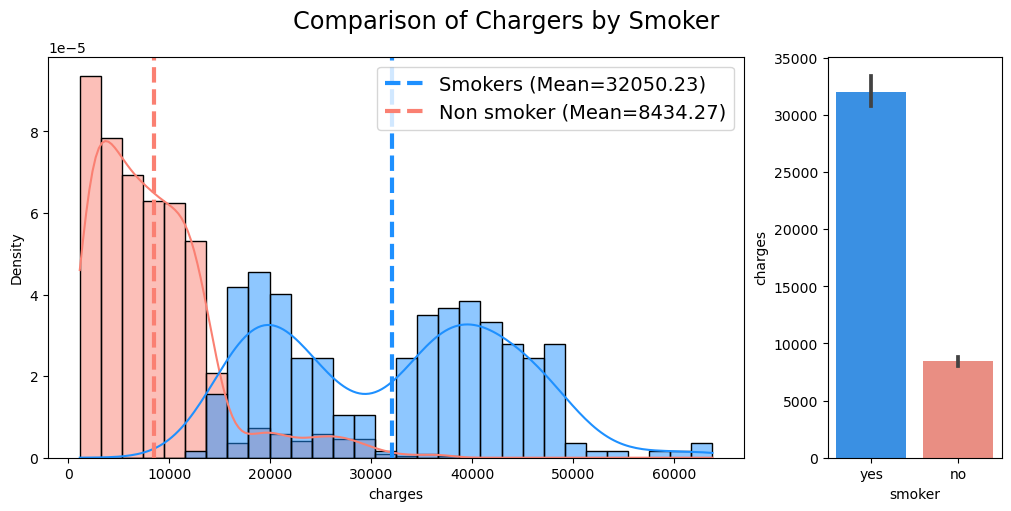

In [138]:
palette={'yes':'dodgerblue', 'no':'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})



# Histogram
ax = sns.histplot(data=df, x='charges',fill='yes',hue='smoker',kde='no',
                  stat='density',common_norm=False,ax=ax,
                  palette=palette)

ax.axvline(np.mean(smoker), ls='--',lw=3, 
           label=f"Smokers (Mean={np.mean(smoker):.2f})",color=palette['yes'])

ax.axvline(np.mean(non_smoker), ls='--', lw=3, 
           label=f"Non smoker (Mean={np.mean(non_smoker):.2f})",color=palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=palette)
fig.suptitle('Comparison of Chargers by Smoker',fontsize='xx-large');

Check for and remove outliers

In [139]:
# Check for outliers in weight for strength group
zscores= stats.zscore(smoker)
outliers = abs(zscores)>3
np.sum(outliers)


0

No outliners for smokers

In [140]:
# check for outliers in weight for no strength group
zscores= stats.zscore(non_smoker)
outliers = abs(zscores)>3
np.sum(outliers)


24

We remove outliners for non smokers

In [141]:
# remove outliers from strength group
non_smoker = non_smoker[(np.abs(stats.zscore(non_smoker)) < 3)]


Check for Normality

In [142]:
# test the strength group for normality
result_smoker = stats.normaltest(smoker)
result_smoker


NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [143]:
# test the strength group for normality
result_non_smoker = stats.normaltest(non_smoker)
result_non_smoker


NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

Check for Equal Variance

In [144]:
# Test for equal variance
result = stats.levene(smoker, non_smoker)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Perform and evaluate the t-test

In [145]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker, non_smoker, equal_var = False)
result



Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

p<0.05, we then reject the null hypothesis and accept that there is a significant difference between the weights of superheroes who have "super strength" and those who do not.

### Hypothesis 2

State the Hypothesis & Null Hypothesis


- $H_0$ (Null Hypothesis):There is no slightly difference between men smokers and women smokers
- $H_A$ (Alternative Hypothesis): There is slightly difference between men smokers and women smokers

- Choosing test 
    - **The appropriate test to perform would be:**
        - Since we are measuring a categorical column (Smoker)
        - and we are comparing 2 groups(Males and Females). 
        - We therefore want to perform a 2-sample t-test, A.K.A. an independent t-test.
    
- **According the the work flow, the 2-sample T-Test has the following assumptions:** 
    - No significant outliers
    - Normality
    - Equal Variance

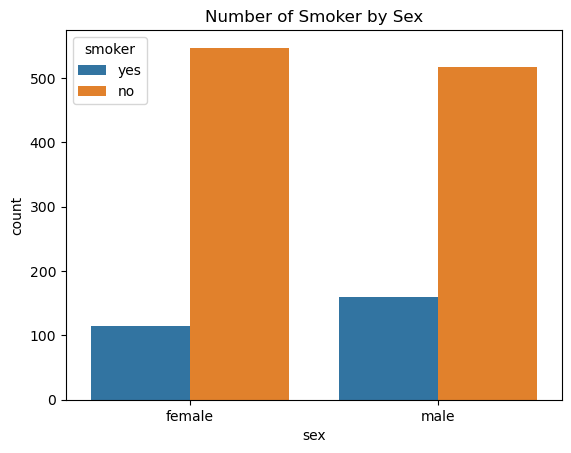

In [146]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smoker by Sex");



In [147]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table



smoker,no,yes
sex,,
female,547,115
male,517,159


In [148]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results



In [149]:
# What was our p-value?
print(p)
p<.05



0.006548143503580696


True

p<0.05, we then reject the null hypothesis and accept there is slightly difference between men smokers and women smokers

### Hypothesis 3

State the Hypothesis & Null Hypothesis


- $H_0$ (Null Hypothesis):Different region all have the same charges
- $H_A$ (Alternative Hypothesis): :Different region have the different charges

In [150]:
- Choosing test 
    - **The appropriate test to perform would be:**
        - Since we are measuring a numeric quantity (Charges)
        - and we are comparing more than 2 groups. 
        - We therefore want to perform a Anova test.
    
- **According the the work flow, the anova test has the following assumptions:** 
    - No significant outliers
    - Normality
    - Equal Variance

SyntaxError: invalid syntax (3962177191.py, line 1)

In [ ]:
ax = sns.barplot(data=df, x='region', y='charges')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

In [ ]:
needed_cols = ['region','charges']
df[needed_cols]

In [ ]:
## Create a dictionary with each group as key and funded_amount as values
groups ={}

for region in df['region'].unique():
    temp = df.loc[df['region']== region, 'charges']
    groups[region] = temp

groups.keys()



## Testing assumptions

In [ ]:
## Loop through groups dict
for region, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {region} group.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    groups[region] = data


In [ ]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for region, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[region] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


In [ ]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



In [ ]:
# with the * operator 
stats.levene(*groups.values())


In [ ]:
## Use an if-else to help interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

In [ ]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

In [ ]:
## make a list for saving the dataframes to
tukeys_dfs = []

## Loop through groups dict's items
for region, temp in groups.items():
    
    ## make a temp_df with the data and the sector name
    temp_df = pd.DataFrame({'charges':temp, 'region':region})
    
    ## append to tukeys_dfs
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe    
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

In [ ]:
## save the values as kg_lost and the labels to the Diet
values = tukeys_data['charges']
labels = tukeys_data['region']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

In [ ]:
## optional -slicing out dataframe from results
summary = tukeys_results.summary()
tukeys_df = pd.DataFrame(summary.data[1:], columns=summary.data[0])
tukeys_df

In [ ]:
## make a barplot of final data to go with results
ax = sns.barplot(data=tukeys_data, x='region', y='charges', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation='45', ha='right');

In [ ]:
## Not significantly different
tukeys_df[tukeys_df['reject'] ==False]

We can see in the summary above that there are 4 no significant results.  

In [ ]:
## Significantly different
tukeys_df[tukeys_df['reject'] ==True]

We can see in the summary above that there are 2 no significant results.  

You can see in the summary above that there are 2 significant results.  We see that there is a significant difference in charges between region northwest and southeast and between regions southeast and southweast. 